In [1]:
import numpy as np
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import random
from skimage import io, exposure
import cv2

In [3]:
import numpy as np 
import tensorflow as tf
import pandas as pd
from tqdm import tqdm
import os
from cv2 import imread, createCLAHE 
import cv2
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

In [6]:
image_path = os.path.join("../input/chest-xray-masks-and-labels/Lung Segmentation/CXR_png")
mask_path = os.path.join("../input/chest-xray-masks-and-labels/Lung Segmentation/masks")
images = os.listdir(image_path)
mask = os.listdir(mask_path)
mask = [fName.split(".png")[0] for fName in mask]
image_file_name = [fName.split("_mask")[0] for fName in mask]

In [7]:
check = [i for i in mask if "mask" in i]
print("Total mask that has modified name:",len(check))

Total mask that has modified name: 566


In [8]:
testing_files = set(os.listdir(image_path)) & set(os.listdir(mask_path))
training_files = check

def getData(X_shape, flag = "test"):
    im_array = []
    mask_array = []
    
    if flag == "test":
        for i in tqdm(testing_files): 
            im = cv2.resize(cv2.imread(os.path.join(image_path,i)),(X_shape,X_shape))[:,:,0]
            mask = cv2.resize(cv2.imread(os.path.join(mask_path,i)),(X_shape,X_shape))[:,:,0]
            
            im_array.append(im)
            mask_array.append(mask)
        
        return im_array,mask_array
    
    if flag == "train":
        for i in tqdm(training_files): 
            im = cv2.resize(cv2.imread(os.path.join(image_path,i.split("_mask")[0]+".png")),(X_shape,X_shape))[:,:,0]
            mask = cv2.resize(cv2.imread(os.path.join(mask_path,i+".png")),(X_shape,X_shape))[:,:,0]

            im_array.append(im)
            mask_array.append(mask)

        return im_array,mask_array

In [9]:
def plotMask(X,y):
    sample = []
    
    for i in range(6):
        left = X[i]
        right = y[i]
        combined = np.hstack((left,right))
        sample.append(combined)
        
        
    for i in range(0,6,3):

        plt.figure(figsize=(25,10))
        
        plt.subplot(2,3,1+i)
        plt.imshow(sample[i])
        
        plt.subplot(2,3,2+i)
        plt.imshow(sample[i+1])
        
        
        plt.subplot(2,3,3+i)
        plt.imshow(sample[i+2])
        
        plt.show()

In [10]:
dim = 256*2
X_train,y_train = getData(dim,flag="train")
X_test, y_test = getData(dim)

100%|██████████| 138/138 [01:02<00:00,  2.20it/s]


training set


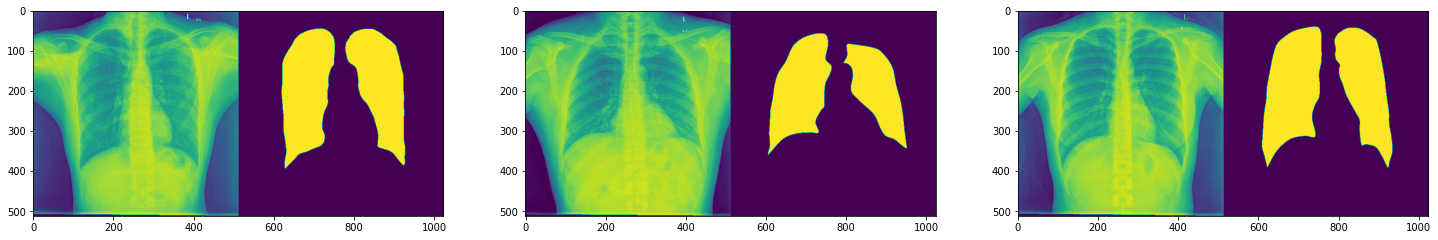

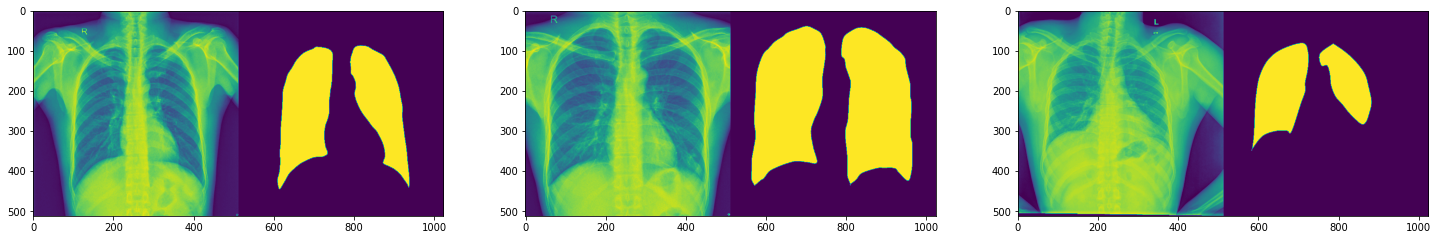

testing set


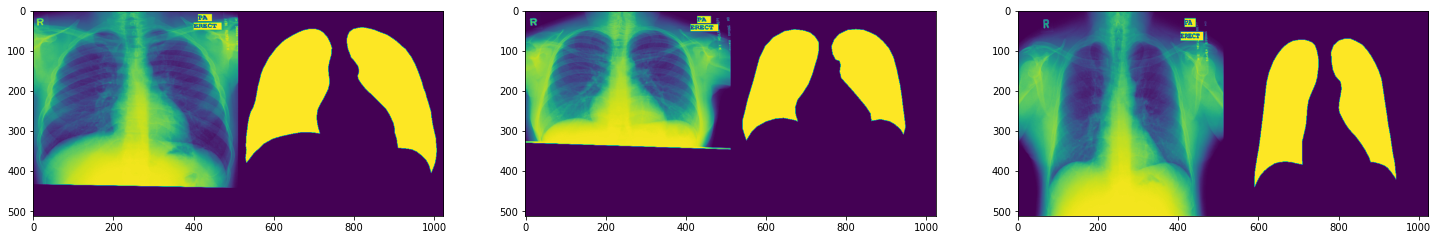

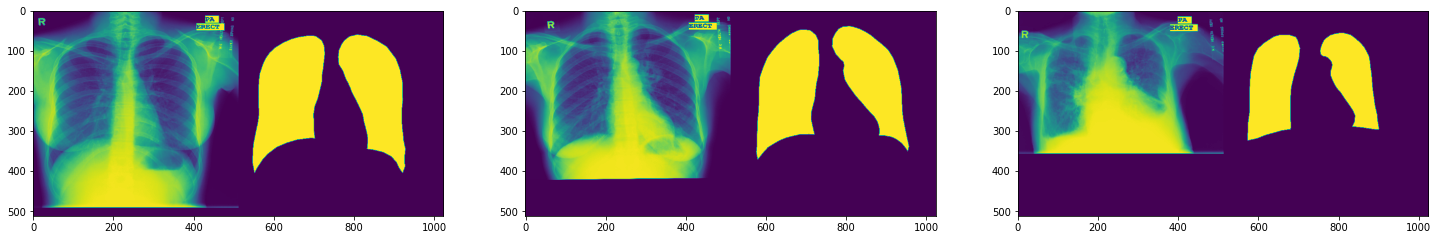

In [11]:
print("training set")
plotMask(X_train,y_train)
print("testing set")
plotMask(X_test,y_test)

In [12]:
X_train = np.array(X_train).reshape(len(X_train),dim,dim,1)
y_train = np.array(y_train).reshape(len(y_train),dim,dim,1)
X_test = np.array(X_test).reshape(len(X_test),dim,dim,1)
y_test = np.array(y_test).reshape(len(y_test),dim,dim,1)
assert X_train.shape == y_train.shape
assert X_test.shape == y_test.shape
images = np.concatenate((X_train,X_test),axis=0)
mask  = np.concatenate((y_train,y_test),axis=0)

U-Net

In [13]:
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras import backend as keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, LearningRateScheduler


def dice_coef(y_true, y_pred):
    y_true_f = keras.flatten(y_true)
    y_pred_f = keras.flatten(y_pred)
    intersection = keras.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (keras.sum(y_true_f) + keras.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def unet(input_size=(256,256,1)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    return Model(inputs=[inputs], outputs=[conv10])

In [17]:
model = unet(input_size=(512,512,1))
model.compile(optimizer=Adam(lr=0.001), loss=dice_coef_loss,
                  metrics=[dice_coef, 'binary_accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 512, 512, 32) 320         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 512, 512, 32) 9248        conv2d_19[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 256, 256, 32) 0           conv2d_20[0][0]                  
____________________________________________________________________________________________

In [18]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('cxr_reg')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.5, 
                                   patience=3, 
                                   verbose=1, mode='min', epsilon=0.0001, cooldown=2, min_lr=1e-6)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=15) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early, reduceLROnPlat]

In [19]:
from IPython.display import clear_output
from keras.optimizers import Adam 
from sklearn.model_selection import train_test_split

model.compile(optimizer=Adam(lr=2e-4), 
              loss=[dice_coef_loss], 
           metrics = [dice_coef, 'binary_accuracy'])

train_vol, validation_vol, train_seg, validation_seg = train_test_split((images-127.0)/127.0, 
                                                            (mask>127).astype(np.float32), 
                                                            test_size = 0.1,random_state = 2018)

train_vol, test_vol, train_seg, test_seg = train_test_split(train_vol,train_seg, 
                                                            test_size = 0.1, 
                                                            random_state = 2018)

loss_history = model.fit(x = train_vol,
                       y = train_seg,
                         batch_size = 16,
                  epochs = 50,
                  validation_data =(test_vol,test_seg) ,
                  callbacks=callbacks_list)

Epoch 1/50
36/36 [==============================] - 29s 606ms/step - loss: -0.3499 - dice_coef: 0.3500 - binary_accuracy: 0.7163 - val_loss: -0.5572 - val_dice_coef: 0.5572 - val_binary_accuracy: 0.8214

Epoch 00001: val_loss improved from inf to -0.55725, saving model to cxr_reg_weights.best.hdf5
Epoch 2/50
36/36 [==============================] - 19s 533ms/step - loss: -0.6371 - dice_coef: 0.6373 - binary_accuracy: 0.8066 - val_loss: -0.7588 - val_dice_coef: 0.7588 - val_binary_accuracy: 0.8939

Epoch 00002: val_loss improved from -0.55725 to -0.75877, saving model to cxr_reg_weights.best.hdf5
Epoch 3/50
36/36 [==============================] - 19s 533ms/step - loss: -0.7687 - dice_coef: 0.7687 - binary_accuracy: 0.8872 - val_loss: -0.7615 - val_dice_coef: 0.7615 - val_binary_accuracy: 0.8942

Epoch 00003: val_loss improved from -0.75877 to -0.76148, saving model to cxr_reg_weights.best.hdf5
Epoch 4/50
36/36 [==============================] - 19s 533ms/step - loss: -0.8224 - dice_coe

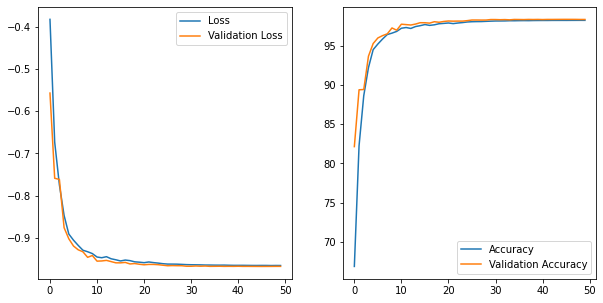

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
ax1.plot(loss_history.history['loss'], '-', label = 'Loss')
ax1.plot(loss_history.history['val_loss'], '-', label = 'Validation Loss')
ax1.legend()

ax2.plot(100*np.array(loss_history.history['binary_accuracy']), '-', 
         label = 'Accuracy')
ax2.plot(100*np.array(loss_history.history['val_binary_accuracy']), '-',
         label = 'Validation Accuracy')
ax2.legend()

In [22]:
images_name = []
for image_path in Path('../input/data/images_001/images/').iterdir():
    if 'png' in image_path.parts[-1]: images_name.append(image_path.parts[-1])
n = len(images_name)
train_img, val_img, test_img = np.split(images_name, [int(0.7*n), int(0.8*n)])

In [29]:
disease_labels = ['Atelectasis', 'Consolidation', 'Infiltration', 'Pneumothorax', 'Edema', 'Emphysema', 'Fibrosis', 'Effusion', 'Pneumonia', 'Pleural_Thickening',
'Cardiomegaly', 'Nodule', 'Mass', 'Hernia']
labels_train_val = pd.read_csv('/kaggle/input/data/train_val_list.txt')
labels_train_val.columns = ['Image_Index']
labels_test = pd.read_csv('/kaggle/input/data/test_list.txt')
labels_test.columns = ['Image_Index']
labels_df = pd.read_csv('/kaggle/input/data/Data_Entry_2017.csv')
labels_df.columns = ['Image_Index', 'Finding_Labels', 'Follow_Up_#', 'Patient_ID',
                  'Patient_Age', 'Patient_Gender', 'View_Position',
                  'Original_Image_Width', 'Original_Image_Height',
                  'Original_Image_Pixel_Spacing_X',
                  'Original_Image_Pixel_Spacing_Y', 'dfd']
for diseases in tqdm(disease_labels): #TQDM is a progress bar setting
    labels_df[diseases] = labels_df['Finding_Labels'].map(lambda result: 1 if diseases in result else 0)

100%|██████████| 14/14 [00:00<00:00, 17.08it/s]


In [30]:
train_val_merge = pd.merge(left=labels_train_val, right=labels_df, left_on='Image_Index', right_on='Image_Index')
test_merge = pd.merge(left=labels_test, right=labels_df, left_on='Image_Index', right_on='Image_Index')
train_val_merge['Finding_Labels'] = train_val_merge['Finding_Labels'].apply(lambda s: [l for l in str(s).split('|')])

test_merge['Finding_Labels'] = test_merge['Finding_Labels'].apply(lambda s: [l for l in str(s).split('|')])
num_glob = glob('/kaggle/input/data/*/images/*.png')
img_path = {os.path.basename(x): x for x in num_glob}
train_val_merge['Paths'] = train_val_merge['Image_Index'].map(img_path.get)
test_merge['Paths'] = test_merge['Image_Index'].map(img_path.get)
patients = np.unique(train_val_merge['Patient_ID'])
test_patients = np.unique(test_merge['Patient_ID'])
print('No. of Unique Patients in Train dataset : ',len(patients))
train_df = train_val_merge[train_val_merge['Patient_ID'].isin(patients)]
print('Training Dataframe   : ', train_df.shape[0],' images')
val_df, test_df = train_test_split(test_patients, test_size = 0.58, random_state = 2019, shuffle= True) 
print('No. of Unique Patients in Validation dataset : ',len(val_df))
val_df = test_merge[test_merge['Patient_ID'].isin(val_df)]
print('Validation Dataframe   : ', val_df.shape[0],' images')
print('No. of Unique Patients in Test dataset : ',len(test_df))
test_df = test_merge[test_merge['Patient_ID'].isin(test_df)]
print('Testing Dataframe   : ', test_df.shape[0],' images')

No. of Unique Patients in Train dataset :  28008
Training Dataframe   :  86523  images
No. of Unique Patients in Validation dataset :  1174
Validation Dataframe   :  10748  images
No. of Unique Patients in Test dataset :  1623
Testing Dataframe   :  14847  images


In [35]:
IMG_SIZE = (512, 512)
train_data_gen = ImageDataGenerator(rescale=1./255,
                              samplewise_center=True, 
                              samplewise_std_normalization=True, 
                              horizontal_flip = True
                             )
test_data_gen = ImageDataGenerator(rescale=1./255)

In [36]:
SEED = 2
BATCH_SIZE = 16
train_gen = train_data_gen.flow_from_dataframe(dataframe=train_df, 
                                                directory=None,
                                                shuffle= True,
                                                seed = SEED,
                                                x_col = 'Paths',
                                                y_col = disease_labels, 
                                                target_size = IMG_SIZE,
                                                class_mode='raw',
                                                classes = disease_labels,
                                                color_mode = 'rgb',
                                                batch_size = BATCH_SIZE)
val_gen = train_data_gen.flow_from_dataframe(dataframe=val_df, 
                                                directory=None,
                                                shuffle= True,
                                                seed = SEED,
                                                x_col = 'Paths',
                                                y_col = disease_labels, 
                                                target_size = IMG_SIZE,
                                                classes = disease_labels,
                                                class_mode='raw',
                                                color_mode = 'rgb',
                                                batch_size = BATCH_SIZE
                                                )

Found 86523 validated image filenames.
Found 10748 validated image filenames.


In [ ]:
pred_candidates = np.random.randint(1,val_gen,10)
preds = model.predict(val_gen)
plt.figure(figsize=(20,10))

for i in range(0,9,3):
    plt.subplot(3,3,i+1)
    
    plt.imshow(np.squeeze(val_gen[pred_candidates[i]]))
    plt.xlabel("Base Image")
    
    plt.subplot(3,3,i+3)
    plt.imshow(np.squeeze(preds[pred_candidates[i]]))
    plt.xlabel("Predicted")